Importing the required packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import explained_variance_score,r2_score
from time import time
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from datetime import datetime, date
import calendar

!pip install holidays
import holidays
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

Loading the dataset into a python dataframe

In [4]:
df = pd.read_csv('/content/train.csv')
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


#### Dataset Exploration

In [5]:
df.shape

(913000, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


Split the data into Train and Test - The dataset is split in such a way that the training dataset contains data from the year 2013 to 2016. WHile, the testing dataset contains data for the year 2017

In [8]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')

train = df[(df["year"] != 2017) & (df["store"] == 1) & (df["item"] == 1)]

test = df[(df["year"] == 2017) & (df["store"] == 1) & (df["item"] == 1)]

In [9]:
print(train)
print(test)

            date  store  item  sales  year
0     2013-01-01      1     1     13  2013
1     2013-01-02      1     1     11  2013
2     2013-01-03      1     1     14  2013
3     2013-01-04      1     1     13  2013
4     2013-01-05      1     1     10  2013
...          ...    ...   ...    ...   ...
1456  2016-12-27      1     1     10  2016
1457  2016-12-28      1     1     16  2016
1458  2016-12-29      1     1     21  2016
1459  2016-12-30      1     1     24  2016
1460  2016-12-31      1     1     14  2016

[1461 rows x 5 columns]
            date  store  item  sales  year
1461  2017-01-01      1     1     19  2017
1462  2017-01-02      1     1     15  2017
1463  2017-01-03      1     1     10  2017
1464  2017-01-04      1     1     16  2017
1465  2017-01-05      1     1     14  2017
...          ...    ...   ...    ...   ...
1821  2017-12-27      1     1     14  2017
1822  2017-12-28      1     1     19  2017
1823  2017-12-29      1     1     15  2017
1824  2017-12-30      1     1

#### Setting up a benchmark (Before preprocessing the data)

Benchmark 1 - The approach followed in this is a very naive forcasting method where we are just taking an average of that particular day for each year and then predicting the value of the next year same day as that average value.
For Example:
Predicted inventory requirement value for Jan 1st 2017 would be Average value of Jan 1st Sales value of the years (2013, 2014, 2015 and 2016)


In [10]:
train["month_day"] = train.date.map(lambda x:str(x)[5:12])

In [11]:
train = train[train["month_day"] != '02-29']

In [12]:
X_Pred = train.groupby("month_day").sales.mean().to_frame()

In [13]:
X_Test = test[["sales"]]

Benchmark 1 - MAPE value to determine accuracy of the model

In [14]:
mape(X_Pred, X_Test)

0.3029780598276817

#### Feature Engineering

To get better results first try to introduce a few other attributes which might help the model predict better. To do so we perform Feature Engineering

In [15]:
#Splitting the Date coumn into Year, Month and Day respectively
parts = df["date"].str.split("-", n=3, expand=True)

# Check and convert columns to numeric, coercing errors to NaN
df["year"] = pd.to_numeric(parts[0], errors='coerce')
df["month"] = pd.to_numeric(parts[1], errors='coerce')
df["day"] = pd.to_numeric(parts[2], errors='coerce')

# Drop rows where any of the Year, Month, or Day columns are NaN
df = df.dropna(subset=["year", "month", "day"])

df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [16]:
from datetime import datetime

# Define the function to check if it's a weekend or weekday
def weekend_or_weekday(year, month, day):
    year = int(year)  # Convert to integer if it's float
    month = int(month)  # Convert to integer if it's float
    day = int(day)  # Convert to integer if it's float

    d = datetime(year, month, day)
    if d.weekday() > 4:  # 5 and 6 correspond to Saturday and Sunday
        return 1  # Weekend
    else:
        return 0

In [17]:
india_holidays = holidays.CountryHoliday('IN', years=df['year'].unique())

# Define the function to check if a date is a holiday
def is_holiday(date):
    return 1 if date in india_holidays else 0

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Apply the function to create the 'india_holiday' column
df['india_holiday'] = df['date'].apply(lambda x: is_holiday(x.date()) if pd.notnull(x) else 0)

df.head()

,date,store,item,sales,year,month,day,india_holiday
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,0


In [18]:
#Adding columns to capture cyclic nature of the data (if any)
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,india_holiday,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,0,0.5,0.866025


In [19]:
#Adding column to identify the day of the week
def which_day(year, month, day):

    d = datetime(year,month,day)
    return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'],
                                                      x['month'],
                                                      x['day']),
                                   axis=1)
df.head()

,date,store,item,sales,year,month,day,india_holiday,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,0,0.5,0.866025,5


In [20]:
df.drop('date', axis=1, inplace=True)

#### Exploratory Data Analysis

In [22]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

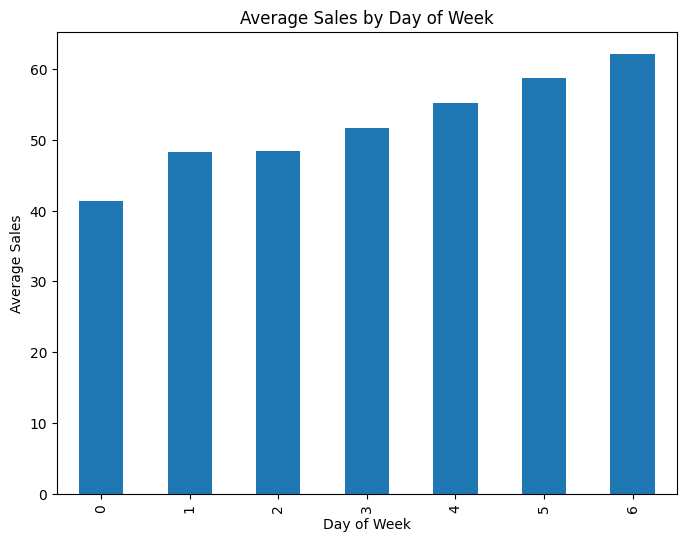

In [26]:
plt.figure(figsize=(8, 6))
df.groupby('weekday')['sales'].mean().plot(kind='bar')
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.show()

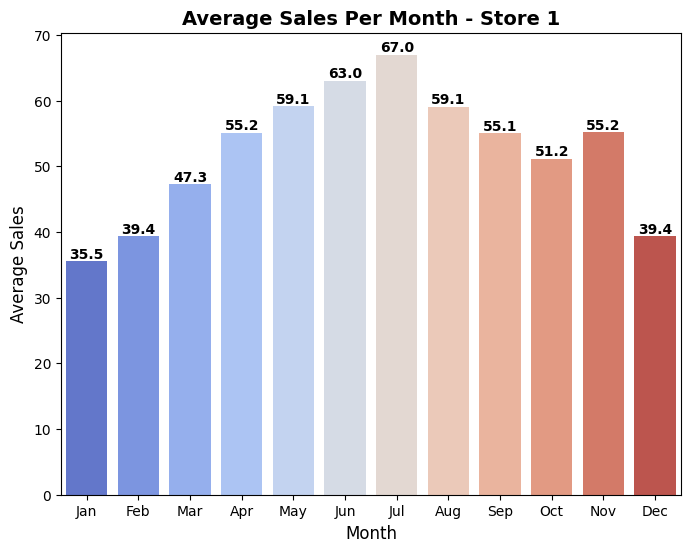

In [25]:
plt.figure(figsize=(8,6))
ax = sb.barplot(x=df.groupby('month')['sales'].mean().index,
                 y=df.groupby('month')['sales'].mean().values,
                 palette="coolwarm")


plt.title("Average Sales Per Month - Store 1", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Sales", fontsize=12)

month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(ticks=range(12), labels=month_labels, fontsize=10)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight="bold")
plt.show()

From here we can conclude that there are 10 unique stores and they sell 50 different products

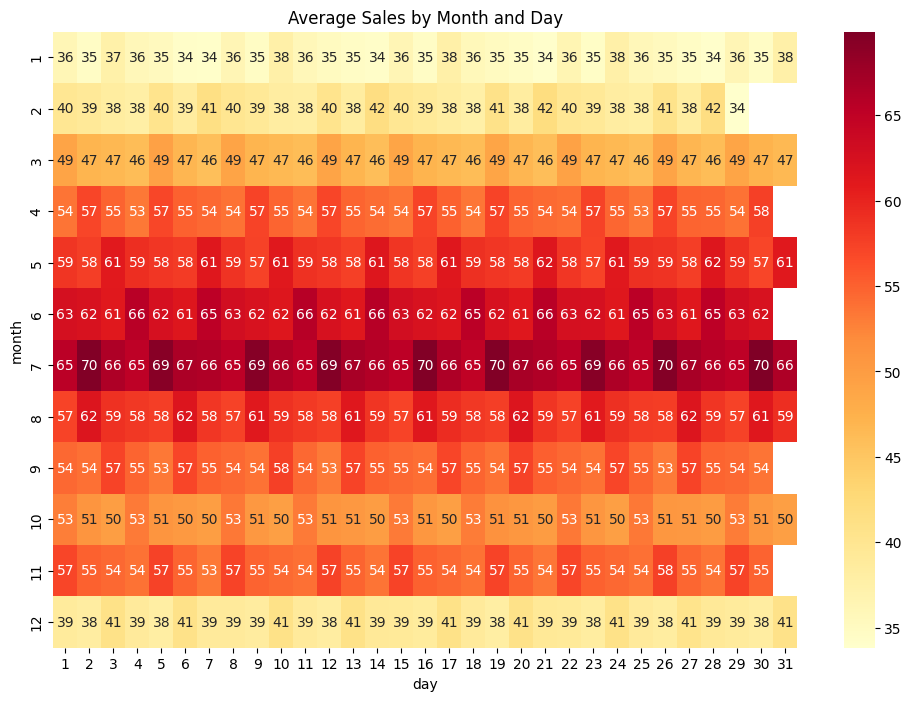

In [28]:
pivot_table = df.pivot_table(values='sales', index='month', columns='day', aggfunc='mean')
plt.figure(figsize=(12, 8))
sb.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Average Sales by Month and Day')
plt.show()

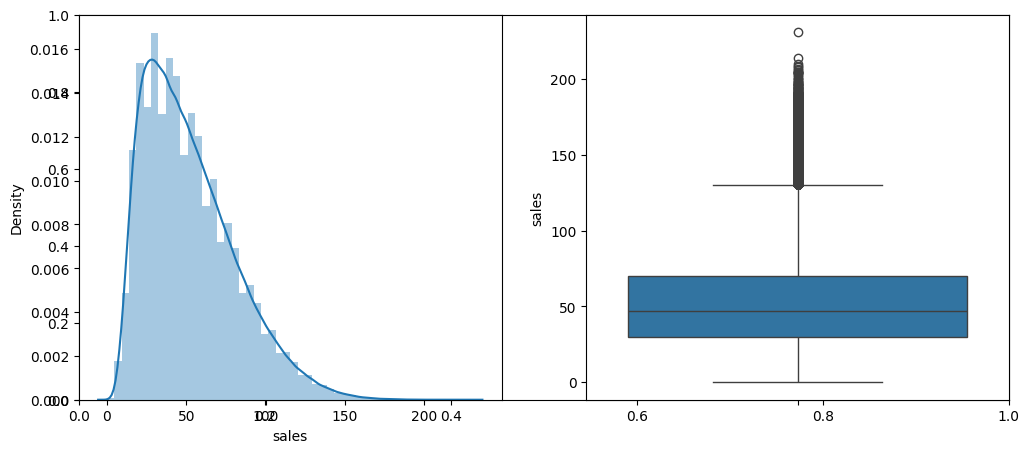

In [41]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()


As per the above graph we can conclude that the values above unit sales > 140 are the outliers. In our analysis we remove them as we want a clean prediction and these values should not skew the results

In [42]:
df = df[df['sales']<140]

#### Benchmark 2: Setting up this benchmark after preprocessing the data

Splitting the dataset into training and testing after preprocessing

In [43]:
train = df[(df["year"] != 2017) & (df["store"] == 1) & (df["item"] >= 1) & (df["item"] <= 10)]

test = df[(df["year"] == 2017) & (df["store"] == 1) & (df["item"] >= 1) & (df["item"] <= 10)]

X_train = train.drop(['sales', 'year'], axis=1)

X_test = test.drop(['sales', 'year'], axis=1)

y_train = train['sales'].values

y_test = test['sales'].values

X_train.shape, X_test.shape

((14610, 8), (3650, 8))

In [44]:
X_train

,store,item,month,day,india_holiday,m1,m2,weekday
0,1,1,1,1,0,5.000000e-01,0.866025,1
1,1,1,1,2,0,5.000000e-01,0.866025,2
2,1,1,1,3,0,5.000000e-01,0.866025,3
3,1,1,1,4,0,5.000000e-01,0.866025,4
4,1,1,1,5,0,5.000000e-01,0.866025,5
...,...,...,...,...,...,...,...,...
165796,1,10,12,27,0,-2.449294e-16,1.000000,1
165797,1,10,12,28,0,-2.449294e-16,1.000000,2
165798,1,10,12,29,0,-2.449294e-16,1.000000,3
165799,1,10,12,30,0,-2.449294e-16,1.000000,4


In [45]:
# Standardization the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Training the dataset on different models to check the results and use the best one for prediction

In [46]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    XGBRegressor(),
    Lasso(),
    Ridge()
]

In [47]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute percentage error:", mape(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.029s
	Prediction time: 0.048s
	Explained variance: 0.7941645563161192
	Mean absolute percentage error: 0.21891696819495282
	R2 score: 0.7436084216084462

GradientBoostingRegressor()
	Training time: 0.891s
	Prediction time: 0.007s
	Explained variance: 0.8890506294663775
	Mean absolute percentage error: 0.16758823099394798
	R2 score: 0.8181016118291751

ExtraTreesRegressor()
	Training time: 2.662s
	Prediction time: 0.101s
	Explained variance: 0.865818773502631
	Mean absolute percentage error: 0.18458018476997595
	R2 score: 0.8153666600420812

RandomForestRegressor()
	Training time: 3.474s
	Prediction time: 0.086s
	Explained variance: 0.8847449028273836
	Mean absolute percentage error: 0.17199776705657796
	R2 score: 0.8295094091115172

DecisionTreeRegressor()
	Training time: 0.047s
	Prediction time: 0.001s
	Explained variance: 0.7777863381216771
	Mean absolute percentage error: 0.22586952428111517
	R2 score: 0.7294824174622513

LinearRegression()
	T

From the above results, we can see that Gradient Boosting performed the best among all the models. Hence we set that as the second benchmark. Now lets see if we can improve its accuracy.

In [48]:
parameters = { 'loss' : ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate' : (0.05,0.25,0.50,1),
              'criterion' : ['friedman_mse', 'mse', 'mae'],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

In [49]:
grid = GridSearchCV(GradientBoostingRegressor(),parameters)
model = grid.fit(X_train,y_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'huber', 'max_features': 'log2'} 

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='log2') 



In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from time import time
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error as mape, r2_score

start = time()
model = GradientBoostingRegressor(learning_rate=0.05, loss='squared_error', max_features='sqrt')  # Changed 'ls' to 'squared_error'
model.fit(X_train, y_train)
train_time = time() - start

start = time()
y_pred = model.predict(X_test)
predict_time = time() - start

# Print the results
print(model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute percentage error:", mape(y_test, y_pred))
print("\tR2 score:", r2_score(y_test, y_pred))

GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt')
	Training time: 0.293s
	Prediction time: 0.004s
	Explained variance: 0.691744032771618
	Mean absolute percentage error: 0.2621486606706066
	R2 score: 0.6208874595941702


In [51]:
train.to_csv('train_dataset.csv', index=False)

print("Train dataset saved as train_dataset.csv")

Train dataset saved as train_dataset.csv


In [52]:
test.head(10)

,store,item,sales,year,month,day,india_holiday,m1,m2,weekday
1461,1,1,19,2017,1,1,0,0.5,0.866025,6
1462,1,1,15,2017,1,2,0,0.5,0.866025,0
1463,1,1,10,2017,1,3,0,0.5,0.866025,1
1464,1,1,16,2017,1,4,0,0.5,0.866025,2
1465,1,1,14,2017,1,5,0,0.5,0.866025,3
1466,1,1,24,2017,1,6,0,0.5,0.866025,4
1467,1,1,14,2017,1,7,0,0.5,0.866025,5
1468,1,1,20,2017,1,8,0,0.5,0.866025,6
1469,1,1,18,2017,1,9,0,0.5,0.866025,0
1470,1,1,11,2017,1,10,0,0.5,0.866025,1


In [53]:
test.head()

,store,item,sales,year,month,day,india_holiday,m1,m2,weekday
1461,1,1,19,2017,1,1,0,0.5,0.866025,6
1462,1,1,15,2017,1,2,0,0.5,0.866025,0
1463,1,1,10,2017,1,3,0,0.5,0.866025,1
1464,1,1,16,2017,1,4,0,0.5,0.866025,2
1465,1,1,14,2017,1,5,0,0.5,0.866025,3


In [54]:
test.tail()

,store,item,sales,year,month,day,india_holiday,m1,m2,weekday
166161,1,10,55,2017,12,27,0,-2.449294e-16,1.0,2
166162,1,10,63,2017,12,28,0,-2.449294e-16,1.0,3
166163,1,10,56,2017,12,29,0,-2.449294e-16,1.0,4
166164,1,10,78,2017,12,30,0,-2.449294e-16,1.0,5
166165,1,10,74,2017,12,31,0,-2.449294e-16,1.0,6


In [55]:
#creating new column in test dataframe
test['predictions_2017'] = y_pred

In [56]:
# Round the values in 'predictions_2017' to the nearest whole number
test['rounded_predictions_2017'] = test['predictions_2017'].round()

In [57]:
test.tail()

,store,item,sales,year,month,day,india_holiday,m1,m2,weekday,predictions_2017,rounded_predictions_2017
166161,1,10,55,2017,12,27,0,-2.449294e-16,1.0,2,43.157789,43.0
166162,1,10,63,2017,12,28,0,-2.449294e-16,1.0,3,46.574481,47.0
166163,1,10,56,2017,12,29,0,-2.449294e-16,1.0,4,49.454038,49.0
166164,1,10,78,2017,12,30,0,-2.449294e-16,1.0,5,51.665721,52.0
166165,1,10,74,2017,12,31,0,-2.449294e-16,1.0,6,52.724797,53.0


In [58]:
test.to_csv('test_df.csv',index=False)

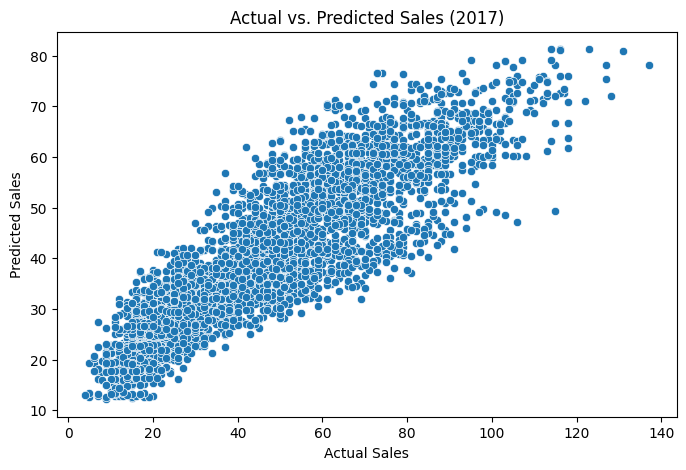

In [60]:
plt.figure(figsize=(8, 5))
sb.scatterplot(x=test["sales"], y=test["predictions_2017"])
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs. Predicted Sales (2017)")
plt.show()

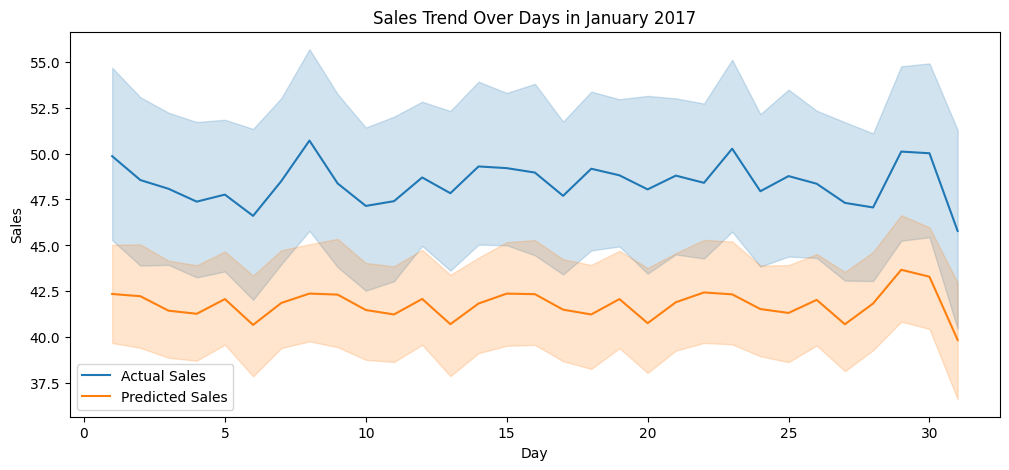

In [61]:
plt.figure(figsize=(12, 5))
sb.lineplot(x=test["day"], y=test["sales"], label="Actual Sales")
sb.lineplot(x=test["day"], y=test["predictions_2017"], label="Predicted Sales")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.title("Sales Trend Over Days in January 2017")
plt.legend()
plt.show()

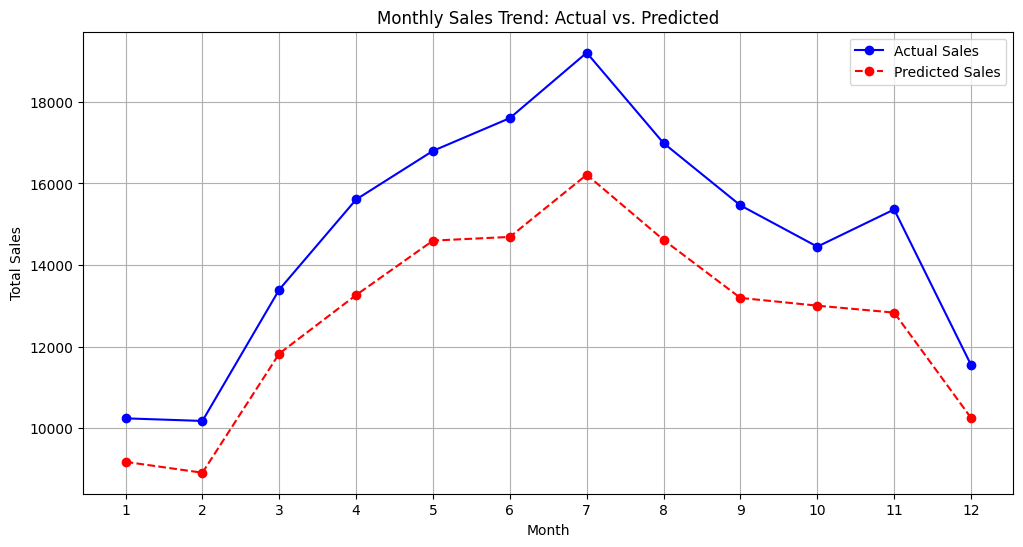

In [64]:
plt.figure(figsize=(12, 6))
test.groupby("month")["sales"].sum().plot(kind="line", marker="o", color="b", label="Actual Sales")
test.groupby("month")["predictions_2017"].sum().plot(kind="line", marker="o", color="r", linestyle="dashed", label="Predicted Sales")

plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trend: Actual vs. Predicted")
plt.legend()
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

all_models = {}

for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(learning_rate=0.05, loss='quantile', max_features='sqrt', alpha=alpha)  # Use 'quantile' loss
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

# MSE model (using squared_error loss)
gbr_mse = GradientBoostingRegressor(learning_rate=0.05, loss='squared_error', max_features='sqrt')
all_models["mse"] = gbr_mse.fit(X_train, y_train)



In [ ]:
y_pred = all_models["mse"].predict(X_test)
y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)
y_med = all_models["q 0.50"].predict(X_test)

In [ ]:
mape(y_test, y_lower)

0.47589936687149714

## Thank You!